In [17]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from train import load_dataset,train,eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
X_train, X_test, y_train, y_test = load_dataset(test_size=0.2)

In [20]:
dec_tree = train('DecisionTree',X_train,y_train,5)
ran_for = train('RandomForest',X_train,y_train,5)
xgb = train('XGB',X_train,y_train,5)
#lbg = train('LGB',X_train,y_train,3)
#cat = train('CAT',X_train,y_train,3)

/home/omarfetou7/anaconda3/envs/ml-lab1/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/omarfetou7/anaconda3/envs/ml-lab1/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'many

In [25]:
dec_tree_logs_test = eval(dec_tree,X_test,y_test)
ran_for_logs_test = eval(ran_for,X_test,y_test)
xgb_logs_test = eval(xgb,X_test,y_test)
#lbg_logs = eval(lbg,X_test,y_test)
#cat_logs = eval(cat,X_test,y_test)

In [26]:
dec_treedf = pd.DataFrame(dec_tree_logs_test['report']).transpose()
ran_fordf = pd.DataFrame(ran_for_logs_test['report']).transpose()
xgbdf = pd.DataFrame(xgb_logs_test['report']).transpose()
#catdf = pd.DataFrame(cat_logs['report']).transpose()

In [27]:
dec_tree_logstrain = eval(dec_tree,X_train,y_train)
ran_for_logstrain = eval(ran_for,X_train,y_train)
xgb_logstrain = eval(xgb,X_train,y_train)

In [28]:
dec_treedftrain = pd.DataFrame(dec_tree_logstrain['report']).transpose()
ran_fordftrain = pd.DataFrame(ran_for_logstrain['report']).transpose()
xgbdftrain = pd.DataFrame(xgb_logstrain['report']).transpose()

In [29]:
dec_treedf

,precision,recall,f1-score,support
0,0.880617,0.992441,0.933191,1323.000000
1,0.969040,0.637475,0.769042,491.000000
accuracy,0.896362,0.896362,0.896362,0.896362
macro avg,0.924829,0.814958,0.851116,1814.000000
weighted avg,0.904551,0.896362,0.888760,1814.000000


In [30]:
dec_treedftrain

,precision,recall,f1-score,support
0,0.886452,0.992632,0.936542,5293.000000
1,0.970610,0.656808,0.783455,1961.000000
accuracy,0.901847,0.901847,0.901847,0.901847
macro avg,0.928531,0.824720,0.859998,7254.000000
weighted avg,0.909203,0.901847,0.895157,7254.000000


In [31]:
ran_fordf

,precision,recall,f1-score,support
0,0.886716,0.993953,0.937277,1323.000000
1,0.975831,0.657841,0.785888,491.000000
accuracy,0.902977,0.902977,0.902977,0.902977
macro avg,0.931273,0.825897,0.861583,1814.000000
weighted avg,0.910837,0.902977,0.896300,1814.000000


In [32]:
ran_fordftrain

,precision,recall,f1-score,support
0,0.998868,1.000000,0.999434,5293.000000
1,1.000000,0.996940,0.998468,1961.000000
accuracy,0.999173,0.999173,0.999173,0.999173
macro avg,0.999434,0.998470,0.998951,7254.000000
weighted avg,0.999174,0.999173,0.999172,7254.000000


In [33]:
xgbdf

,precision,recall,f1-score,support
0,0.907381,0.947846,0.927172,1323.0000
1,0.840278,0.739308,0.786566,491.0000
accuracy,0.891400,0.891400,0.891400,0.8914
macro avg,0.873829,0.843577,0.856869,1814.0000
weighted avg,0.889218,0.891400,0.889114,1814.0000


In [34]:
xgbdftrain

,precision,recall,f1-score,support
0,0.970621,0.992443,0.981411,5293.000000
1,0.978284,0.918919,0.947673,1961.000000
accuracy,0.972567,0.972567,0.972567,0.972567
macro avg,0.974453,0.955681,0.964542,7254.000000
weighted avg,0.972693,0.972567,0.972290,7254.000000


In [35]:
import matplotlib.pyplot as plt

In [36]:
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most significant features based on feature importance from a fitted model.
    Args:
        model: Trained tree-based model with feature_importances_ attribute.
        feature_names: List of feature names.
        top_n: Number of top features to display.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_features = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(top_features)

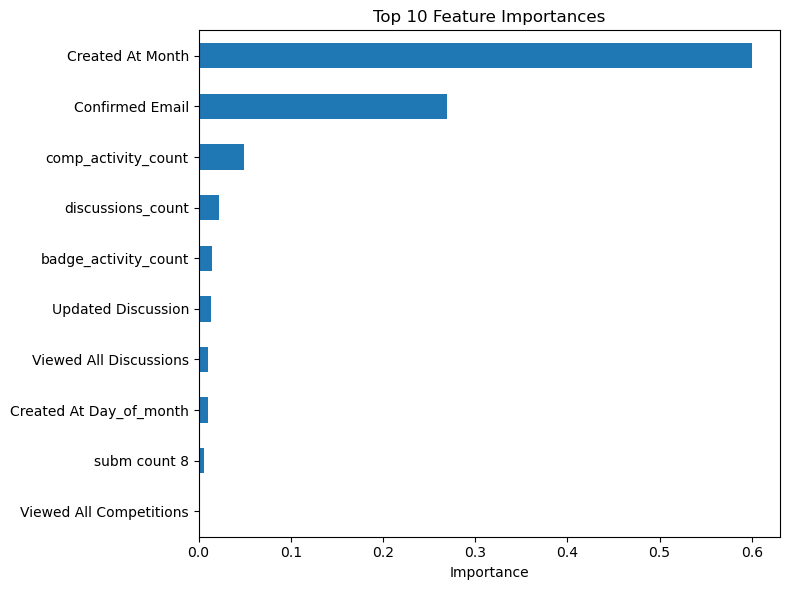

Created At Month           0.600646
Confirmed Email            0.269130
comp_activity_count        0.049582
discussions_count          0.022458
badge_activity_count       0.015031
Updated Discussion         0.013125
Viewed All Discussions     0.010712
Created At Day_of_month    0.009848
subm count 8               0.005998
Viewed All Competitions    0.001444
dtype: float64


In [38]:
plot_feature_importance(dec_tree.best_estimator_.get_params()['model'],X_train.columns)